In [4]:
# theano imports
import theano
from theano import tensor as T
from theano.sandbox.rng_mrg import MRG_RandomStreams as RandomStreams
from theano.tensor.nnet.conv import conv2d
# from theano.tensor.signal.downsample import max_pool_2d
from theano.tensor.signal.pool import pool_2d as max_pool_2d

# other imports
from sklearn.cross_validation import train_test_split
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# import warnings
# warnings.filterwarnings("ignore")

In [6]:
# read our data in 
with open('conv_data/5_tensor.p', 'rb') as f:
    loaded_data = pickle.load(f)

labels = pd.read_csv('one_hot_labels.csv')

In [7]:
loaded_data[:2]    

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]])

In [8]:
one_hot = labels.values

In [9]:
one_hot[:2]

array([[0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1]])

In [10]:
xTrain, xTest, yTrain, yTest = train_test_split(loaded_data, one_hot)

In [11]:
print xTrain.shape, xTest.shape, yTrain.shape, yTest.shape

(101110, 5, 21) (33704, 5, 21) (101110, 6) (33704, 6)


In [12]:
xTrain = xTrain.reshape(-1, 1, 5, 21)
xTest = xTest.reshape(-1, 1, 5, 21)

In [13]:
print xTrain.shape
print xTest.shape
print yTrain.shape
print yTest.shape

(101110, 1, 5, 21)
(33704, 1, 5, 21)
(101110, 6)
(33704, 6)


In [14]:
# example

import theano
from theano import tensor as T
import numpy as np
from theano.tensor.signal.downsample import max_pool_2d
from theano.tensor.nnet.conv import conv2d

X = theano.shared(np.array(range(10*1*5*21), dtype=theano.config.floatX).reshape((10, 1, 5, 21)))

w = theano.shared(np.array(range(256*5*21), dtype=theano.config.floatX)).reshape((256, 1, 5, 21))

convOut = conv2d(X, w, border_mode='valid')  #border_mode={'valid', 'full'}

convOut = convOut.reshape((-1, 256))

convOutTest = convOut.eval()
print convOutTest
print convOutTest.shape

[[  1.87460000e+05   7.60760000e+05   1.33406000e+06 ...,   1.45232352e+08
    1.45805664e+08   1.46378960e+08]
 [  7.60760000e+05   2.49168500e+06   4.22261000e+06 ...,   4.38684928e+08
    4.40415648e+08   4.42146304e+08]
 [  1.33406000e+06   4.22261000e+06   7.11116000e+06 ...,   7.32137024e+08
    7.35025472e+08   7.37914176e+08]
 ..., 
 [  4.20056000e+06   1.28772350e+07   2.15539100e+07 ...,   2.19939917e+09
    2.20807578e+09   2.21675213e+09]
 [  4.77386000e+06   1.46081600e+07   2.44424440e+07 ...,   2.49285171e+09
    2.50268570e+09   2.51251994e+09]
 [  5.34716000e+06   1.63390850e+07   2.73310100e+07 ...,   2.78630400e+09
    2.79729562e+09   2.80828749e+09]]
(10, 256)


In [15]:
srng = RandomStreams()

def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

def glorot_init_weights(shape):
    (h, w) = shape
    normalizer = 2.0 * sqrt(6) / sqrt(h + w) * 0.1  #factors: correct for uni[0,1], glo, glo, softmax deriv
    return theano.shared(floatX((np.random.random_sample(shape) - 0.5) * normalizer))

def init_weights(shape):
    return theano.shared(floatX(np.random.randn(*shape) * 0.01))

def activate(X):
    return T.nnet.relu(X)

def rectify(X):
    return T.maximum(X, 0.)
    #return T.maximum(X, 0.01*X)  #leaky rectifier

def softmax(X):
    e_x = T.exp(X - X.max(axis=1).dimshuffle(0, 1, 'x', 'x'))
    return e_x / e_x.sum(axis=1).dimshuffle(0, 1, 'x', 'x')

def dropout(X, p=0.0):
    if p > 0:
        retain_prob = 1 - p
        X *= srng.binomial(X.shape, p=retain_prob, dtype=theano.config.floatX)
        X /= retain_prob
    return X

def RMSprop(cost, params, lr=0.001, rho=0.9, epsilon=1e-6):
    grads = T.grad(cost=cost, wrt=params)
    updates = []
    
    for p, g in zip(params, grads):
        acc = theano.shared(p.get_value() * 0.)
        acc_new = rho * acc + (1 - rho) * g ** 2
        gradient_scaling = T.sqrt(acc_new + epsilon)
        g = g / gradient_scaling
        updates.append((acc, acc_new))
        updates.append((p, p - lr * g))
    
    return updates

def model(X, wi, wh, wo, p_drop_conv, p_drop_hidden):
    layer_1 = rectify(conv2d(X, wi, border_mode='valid')) # , border_mode='full'
    layer_1 = layer_1.reshape((-1, 256))
    #     layer_1 = dropout(layer_1, p_drop_conv)

    layer_2 = rectify(T.dot(layer_1, wh))
#     layer_2 = dropout(layer_2, p_drop_hidden)

#     pyx = softmax(T.dot(layer_2, wo))
    pyx = T.nnet.softmax(T.dot(layer_2, wo))
    return layer_1, layer_2, pyx

### Likely need Batch Normalization (Hollis)

In [60]:
X = T.ftensor4()
Y = T.fmatrix()

# define mini-batch size
mbs = 128

# define number of desired features out of convolution
n_conv = 256

# define hidden layer depth
h_depth = 600

wi = init_weights((n_conv, 1, 5, 21))
wh = init_weights((n_conv, h_depth))
wo = init_weights((h_depth, 6))

noise_l1, noise_l2, noise_py_x = model(X, wi, wh, wo, 0.2, 0.5)
l1, l2, py_x = model(X, wi, wh, wo, 0., 0.)
y_x = T.argmax(py_x, axis=1)


cost = T.mean(T.nnet.categorical_crossentropy(noise_py_x, Y))
params = [wi, wh, wo]
updates = RMSprop(cost, params) #lr=1e-7 <--- way too small of a LR

train = theano.function(inputs=[X, Y], outputs=cost, updates=updates, allow_input_downcast=True)
predict = theano.function(inputs=[X], outputs=y_x, allow_input_downcast=True)

In [61]:
# number of training iterations to perform
n_train = 21

# store our results
costs = []
scores = []

# performing our training
for i in xrange(n_train):
    
    for start, end in zip(xrange(0, len(xTrain), mbs), 
                          xrange(mbs, len(xTrain), mbs)):
    
        cost = train(xTrain[start:end], yTrain[start:end])
    
    costs.append(cost)
    
    score = np.mean(np.argmax(yTest, axis=1) == predict(xTest))
    
    scores.append(score)
    
    print i, round(score, 3)
    print wi.eval()[0][0][0][:5] # take a quick look at conv filter
    
# got up to about 67% !

0 0.605
[-0.0233094  -0.02309317  0.00671188  0.0149905   0.02146812]
1 0.616
[-0.05716702 -0.02921167  0.03698606  0.01130439  0.00893313]
2 0.622
[-0.09407708 -0.0288817   0.06694144  0.01497058 -0.02152738]
3 0.627
[-0.09670379 -0.01445446  0.06120246  0.03579619 -0.01665369]
4 0.63
[-0.10047964  0.00387215  0.0524274   0.06131239 -0.01179141]
5 0.631
[-0.10349248  0.02099101  0.04977395  0.08136492 -0.00341165]
6 0.633
[-0.11234646  0.03019206  0.05510927  0.09410118  0.00107217]
7 0.635
[-0.11734834  0.036755    0.06298663  0.09631077 -0.00178568]
8 0.637
[-0.12598644  0.03896995  0.07019091  0.09729365 -0.00270595]
9 0.638
[-0.13798545  0.04670335  0.0732359   0.09790806 -0.0024955 ]
10 0.639
[-0.14892456  0.05219776  0.07622778  0.09994201  0.0092287 ]
11 0.642
[-0.17335874  0.05827783  0.08592258  0.10251077  0.01516241]
12 0.643
[-0.19195294  0.06382207  0.08497933  0.10013199  0.02731975]
13 0.645
[-0.20769903  0.06293327  0.08384897  0.09566545  0.04293518]
14 0.647
[-0.2152

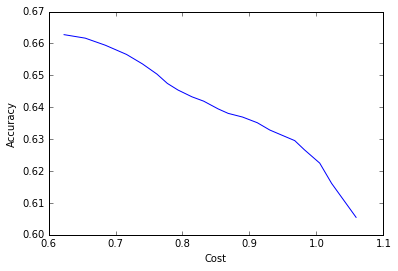

In [62]:
# plot our results
plt.plot(costs, scores)
plt.xlabel('Cost')
plt.ylabel('Accuracy');

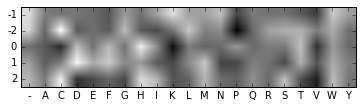

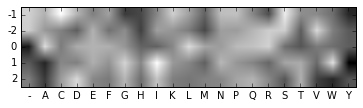

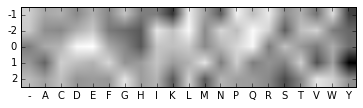

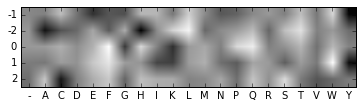

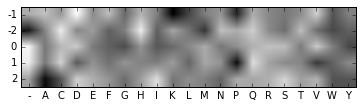

In [70]:
# eventually have NaN problems!

# AMINO MAPS
aminos = ['-','A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
positions = ['-1', '-2', '0', '1', '2']

for conv in wi.eval()[:5]:
    c = conv.reshape(5, 21)
    plt.imshow(c, cmap='Greys')
    plt.xticks(range(len(aminos)), aminos)
    plt.yticks(range(len(positions)), positions)
#     plt.colorbar()
    plt.show()

# first_conv = wi.eval()[0]
# first_conv = first_conv.reshape(5, 21)
# plt.imshow(first_conv, cmap='Greys');

http://deeplearning.net/software/theano/library/tensor/nnet/nnet.html#tensor.nnet.softmax
http://deeplearning.net/software/theano/library/tensor/nnet/conv.html#theano.tensor.nnet.conv.conv2d